# Pickling cuML Models for Persistence

This notebook demonstrates simple pickling of both single-GPU and multi-GPU cuML models for persistence

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Single GPU Model Pickling

All single-GPU estimators are pickleable. The following example demonstrates the creation of a synthetic dataset, training, and pickling of the resulting model for storage. Trained single-GPU models can also be used to distribute the inference on a Dask cluster, which the `Distributed Model Pickling` section below demonstrates.

In [2]:
from cuml.datasets import make_blobs

X, y = make_blobs(n_samples=50, 
                  n_features=10, 
                  centers=5, 
                  cluster_std=0.4, 
                  random_state=0)

In [3]:
from cuml.cluster import KMeans

model = KMeans(n_clusters=5)

model.fit(X)

KMeans(handle=<cuml.raft.common.handle.Handle object at 0x7f96ccdc9bf0>, n_clusters=5, max_iter=300, tol=0.0001, verbose=4, random_state=1, init='scalable-k-means++', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='input')

In [4]:
import pickle

pickle.dump(model, open("kmeans_model.pkl", "wb"))

In [5]:
model = pickle.load(open("kmeans_model.pkl", "rb"))

In [6]:
model.labels_

array([3, 0, 1, 0, 2, 2, 1, 2, 4, 2, 2, 2, 0, 3, 3, 1, 0, 0, 2, 3, 1, 1,
       1, 4, 3, 3, 4, 0, 1, 3, 2, 1, 4, 0, 1, 3, 2, 1, 3, 0, 1, 0, 4, 0,
       3, 3, 2, 0, 2, 1], dtype=int32)

## Distributed Model Pickling

The distributed estimator wrappers inside of the `cuml.dask` are not intended to be pickled directly, as they will often contain extra information internally, such as connection information about the Dask cluster used for training. Instead, the Dask cuML estimators provide a function `get_combined_model()`, which returns the trained single-GPU model and can be pickled. The combined model will can be used for inference on a single-GPU, and the `ParallelPostFit` wrapper from the [Dask-ML](https://ml.dask.org/meta-estimators.html) library can be used to distributed inference on a Dask cluster.

In this simple example, we will create a Dask cluster with one worker mapped to each GPU on the local physical machine. We'll create a synthetic dataset distributed across the Dask workers, train a K-means model, and demonstrate the pickling of that model.

In [7]:
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()
client = Client(cluster)
client

/share/software/miniconda3/envs/cuml_017_103020/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40971 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:46573 Dashboard: http://127.0.0.1:40971/status,Cluster Workers: 2 Cores: 2 Memory: 50.39 GB


We will use `make_blobs` from the `cuml.dask.datasets` package to create create a distributed dataset of clustered points for this example. 

In [8]:
from cuml.dask.datasets import make_blobs

n_workers = len(client.scheduler_info()["workers"].keys())

X, y = make_blobs(n_samples=5000, 
                  n_features=30,
                  centers=5, 
                  cluster_std=0.4, 
                  random_state=0,
                  n_parts=n_workers*5)

X = X.persist()
y = y.persist()

We verify the distribution of the data across the Dask workers

In [9]:
client.has_what()

{'tcp://127.0.0.1:46298': (), 'tcp://127.0.0.1:46704': ()}

### Train Distributed Model

In [10]:
from cuml.dask.cluster import KMeans

dist_model = KMeans(n_clusters=5)

The combined model returns `None` when not yet trained

In [11]:
print(dist_model.get_combined_model())

None


In [12]:
dist_model.fit(X)

When an attribute doesn't exist on the distributed model, it is proxied to the underlying single-GPU models.

Note: If needed, we could move the proxy logic into a function that can be overrided in subclasses for special cases (e.g., random forests). 

In [13]:
dist_model.cluster_centers_

array([[-2.9020925 ,  4.463565  , -4.4427094 ,  2.3719027 ,  1.754001  ,
        -2.4955208 , -5.2054358 , -1.7240267 , -8.127401  ,  2.6504474 ,
        -4.299597  ,  5.6064153 , -5.7395763 , -1.7248514 , -9.357102  ,
         0.6998829 ,  4.4257264 , -2.8838768 , -4.9503736 ,  9.685088  ,
         8.412251  , -6.23566   , -6.3632874 ,  1.9591737 ,  4.1670237 ,
        -9.153275  ,  4.603081  ,  8.797906  ,  6.8343625 ,  2.2377446 ],
       [-6.9521384 , -9.75687   , -6.5682516 , -0.4416489 ,  6.092376  ,
         3.7397556 , -3.9585989 ,  6.173612  , -1.8475274 ,  5.0108423 ,
        -6.849037  ,  1.3506444 ,  9.007689  , -1.0089554 ,  9.673699  ,
         9.785972  , -8.635385  ,  5.9851184 ,  2.2260423 , -3.6438909 ,
         7.0530643 , -7.3746967 , -5.3177795 , -6.97397   , -7.919112  ,
         6.684978  , -5.586685  ,  7.132586  ,  6.583669  , -8.290217  ],
       [ 6.2495494 ,  9.245422  ,  8.364465  ,  9.021309  ,  7.6980543 ,
        -0.99231136, -6.271332  ,  1.405315  , -6

If an attribute doesn't exist, we get an error

In [14]:
try:
    dist_model.cluster_centers_fail_
except AttributeError:
    print("Failed")

Failed


The MG subclass also provides the ability to treat attributes differently when they don't make sense in the distributed context. 

For example, calling `combined_model.labels_` would only reference the labels for one partition. Collecting the labels assigned to the training inputs onto a single GPU will not scale, so this attribute gets blanked out in the MG version

In [15]:
print(dist_model.labels_)

None


If needed, the labels can be computed again

In [16]:
y_hat = dist_model.predict(X).compute().get()

### Visualize Clusters

Plot ground truth clusters

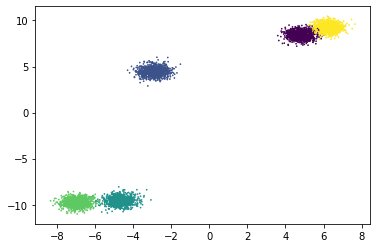

In [17]:
import matplotlib.pyplot as plt

X_host = X.compute().get()
y_host = y.compute().get()

plt.scatter(X_host[:,0], X_host[:,1], c=y_host, s=0.5)

Plot predicted clusters

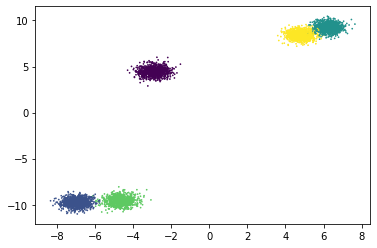

In [18]:
plt.scatter(X_host[:,0], X_host[:,1], c=y_hat, s=0.5)

### Extract combined single-GPU model

In [19]:
single_gpu_model = dist_model.get_combined_model()
type(single_gpu_model)

cuml.cluster.kmeans_mg.KMeansMG

In [20]:
single_gpu_model.cluster_centers_

array([[-2.9020925 ,  4.463565  , -4.4427094 ,  2.3719027 ,  1.754001  ,
        -2.4955208 , -5.2054358 , -1.7240267 , -8.127401  ,  2.6504474 ,
        -4.299597  ,  5.6064153 , -5.7395763 , -1.7248514 , -9.357102  ,
         0.6998829 ,  4.4257264 , -2.8838768 , -4.9503736 ,  9.685088  ,
         8.412251  , -6.23566   , -6.3632874 ,  1.9591737 ,  4.1670237 ,
        -9.153275  ,  4.603081  ,  8.797906  ,  6.8343625 ,  2.2377446 ],
       [-6.9521384 , -9.75687   , -6.5682516 , -0.4416489 ,  6.092376  ,
         3.7397556 , -3.9585989 ,  6.173612  , -1.8475274 ,  5.0108423 ,
        -6.849037  ,  1.3506444 ,  9.007689  , -1.0089554 ,  9.673699  ,
         9.785972  , -8.635385  ,  5.9851184 ,  2.2260423 , -3.6438909 ,
         7.0530643 , -7.3746967 , -5.3177795 , -6.97397   , -7.919112  ,
         6.684978  , -5.586685  ,  7.132586  ,  6.583669  , -8.290217  ],
       [ 6.2495494 ,  9.245422  ,  8.364465  ,  9.021309  ,  7.6980543 ,
        -0.99231136, -6.271332  ,  1.405315  , -6

### Save & load model

Serialize model to disk 

In [21]:
import pickle
pickle.dump(single_gpu_model, open("kmeans_model.pkl", "wb"))

Load serialized model

In [22]:
single_gpu_model = pickle.load(open("kmeans_model.pkl", "rb"))
type(single_gpu_model)

cuml.cluster.kmeans_mg.KMeansMG

### Perform Single GPU Inference & Visualize

In [23]:
y_hat = single_gpu_model.predict(X.compute()).get()

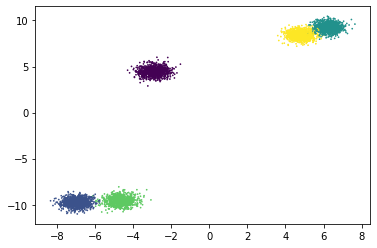

In [24]:
plt.scatter(X_host[:,0], X_host[:,1], c=y_hat, s=0.5)

### Perform Distributed Inference & Visualize

cuML estimators support the `ParallelPostFit` wrapper from the Dask-ML project, which can use the loaded single-GPU model to perform distributed inference on a Dask cluster. Refer to the [Dask-ML API Docs](https://ml.dask.org/meta-estimators.html) for more information about `ParallelPostFit`.

In [25]:
from dask_ml.wrappers import ParallelPostFit

dist_model = ParallelPostFit(estimator=single_gpu_model)

In [26]:
y_hat = dist_model.predict(X).compute()

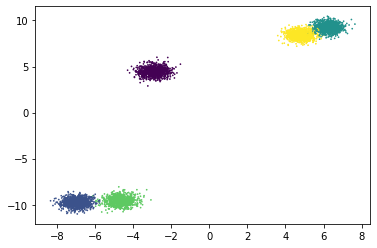

In [27]:
plt.scatter(X_host[:,0], X_host[:,1], c=y_hat.get(), s=0.5)